In [1]:
%matplotlib inline

import numpy as np
from scipy.stats import norm
import pandas as pd
import networkx as nx

from sklearn.metrics.pairwise import cosine_similarity

import matplotlib.pyplot as plt

from keras.layers import Input, Dense, Dropout, BatchNormalization
from keras.models import Model
from keras.constraints import unit_norm
from keras.regularizers import l2

Using Theano backend.
Using cuDNN version 5110 on context None
Mapped name None to device cuda: GeForce GT 650M (0000:01:00.0)


In [2]:
G = nx.read_gml("galFiltered.gml").to_undirected()
G = max(nx.connected_component_subgraphs(G), key=len)

In [3]:
labels = nx.get_node_attributes(G, "label")

genes_in_network = labels.values()

expression_data = pd.read_csv("galExpData.csv")

genes_in_expression_data = expression_data.loc[:,["GENE"]].as_matrix().flatten()

genes_in_network = [gene for gene in genes_in_network if gene in genes_in_expression_data]

# subnetwork that is labelled
nodes_of_interest = [k for k, v in nx.get_node_attributes(G, "label").items() if v in genes_in_network]
G = G.subgraph(nodes_of_interest)

N = nx.number_of_nodes(G)

p_values = expression_data.set_index("GENE").loc[genes_in_network,["gal1RGsig", "gal4RGsig", "gal80Rsig"]].as_matrix()

In [4]:
z_values = norm.ppf(1 - p_values)
z_values[z_values < 0] = 0
# z_values = 1 - p_values

In [5]:
z_values = z_values[:, 0, np.newaxis]

In [6]:
A = np.array(nx.adjacency_matrix(G).todense())
Z = z_values.dot(z_values.transpose())

A = Z * A

D = A.sum(axis=0, dtype=float)

T = A.dot(np.diag(1/D))

In [7]:
G = nx.from_numpy_matrix(A)
G = max(nx.connected_component_subgraphs(G), key=len)

In [8]:
labels = {k: v for k,v in labels.items() if k in G.nodes()}

nx.set_node_attributes(G, "label", labels)

In [9]:
N = nx.number_of_nodes(G)

In [10]:
A = np.array(nx.adjacency_matrix(G).todense())
D = A.sum(axis=0)

In [11]:
L = np.array(nx.laplacian_matrix(G).todense())

In [12]:
W = A.dot(np.diag(1./D))

In [13]:
# A_norm = A / np.array(nx.degree(G).values())[:, np.newaxis]

In [14]:
# D_norm = A_norm.sum(axis=0)

In [15]:
# L_norm = np.diag(D_norm) - A_norm

In [16]:
l, U = np.linalg.eigh(L)

In [17]:
theta = np.arctan2(U[:,2], U[:,1])

In [18]:
theta[theta < 0] += 2 * np.pi

In [51]:
# theta = theta.argsort() * 2 * np.pi / N

In [19]:
stationary_distribution = D / D.sum()

In [21]:
sorted_nodes = stationary_distribution.argsort()[::-1]

In [22]:
beta = 1.0 / (3 - 1)

In [23]:
radial = 2 * beta * np.log(range(1, N + 1)) + 2 * (1 - beta) * np.log(N + 1)

In [24]:
radial[sorted_nodes] = radial

In [25]:
cartesian = radial[:,np.newaxis] * np.column_stack((np.cos(theta), np.sin(theta)))

In [26]:
best_module = np.genfromtxt("best_active_module.txt", dtype=str)

c = ["r" if v in best_module else "b" for v in nx.get_node_attributes(G, "label").values()]

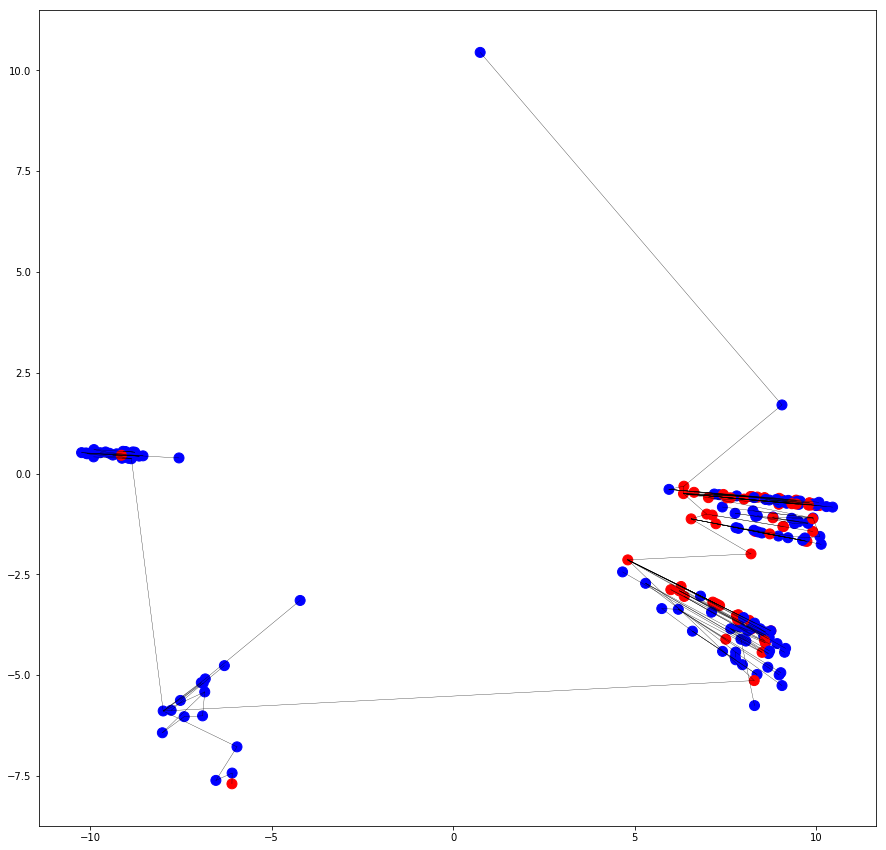

In [28]:
plt.figure(figsize=(15, 15))

# for label, i, j in zip(genes_in_network, cartesian[:10, 0], cartesian[:10, 1]):
#     plt.annotate(
#         label,
#         xy=(i, j), xytext=(-20, 20),
#         textcoords='offset points', ha='right', va='bottom',
#         bbox=dict(boxstyle='round,pad=0.5', fc='yellow', alpha=0.5),
#         arrowprops=dict(arrowstyle = '->', connectionstyle='arc3,rad=0'))

nodes = np.array(G.nodes())
for n1, n2 in G.edges():
    i, = np.where(nodes == n1)
    j, = np.where(nodes == n2)
    plt.plot(cartesian[(i, j), 0], cartesian[(i, j), 1], c="k", 
             linewidth = 0.3)


plt.scatter(cartesian[:,0], cartesian[:,1], 
            c = c,
           s = 100)

In [29]:
def matrix_multiply(M, n):
    if n == 0:
        return np.identity(M.shape[0])
    if n % 2 == 0:
        m = matrix_multiply(M, n/2).dot(matrix_multiply(M, n/2))
    else: m = M.dot(matrix_multiply(M, n-1))
    m[m < 0] = 0
    return m / m.sum(axis=0)

In [57]:
target_distributions = matrix_multiply(W, 100).transpose()

In [31]:
node_representation = np.identity(N)

In [32]:
x = Input(shape=(N,))
# y = Dense(256, activation="tanh")(x)
# y = Dropout(0.5)(y)
y = Dense(128, activation="tanh")(x)
# y = BatchNormalization()(y)
y = Dropout(0.5)(y)
y = Dense(64, activation="tanh")(y)
# y = BatchNormalization()(y)
y = Dropout(0.5)(y)
embedding = Dense(2, activation="linear", activity_regularizer=l2())(y)
# embedding = BatchNormalization()(embedding)
observation_probabilities = Dense(N, activation="softmax", kernel_regularizer=l2())(embedding)

model = Model(x, observation_probabilities)

In [37]:
from theano.tensor import _shared
from keras.objectives import kullback_leibler_divergence
import keras.backend as K

In [49]:
np_array = np.array([1,2,3,4])

In [50]:
t_a = _shared(np_array)

In [56]:
K.tensor.arccos(t_a)

AttributeError: 'module' object has no attribute 'tensor'

In [44]:
def hyperbolic_distance(xi, xj):
#     xi = xi.eval()
#     xj = xj.eval()
    if np.array_equal(xi, xj): return 0
    delta =np.pi - np.abs(np.pi - np.abs(xi[1] - xj[1]))
    d = np.cosh(xi[0]) * np.cosh(xj[0]) - np.sinh(xi[0]) * np.sinh(xj[0]) * np.cos(delta)
    if d < 1: d = 1
    d = np.arccosh(d)
    return d

def compute_probabilities(X):
    
    D = np.array([[hyperbolic_distance(xi, xj) for xj in X] for xi in X])
    
    P = np.exp(-D)
    
    return P / P.sum(axis=1)[:,np.newaxis]


def custom_loss(y_true, y_pred):
    
    y_pred = y_pred.eval()
    
    predicted_probabilities = compute_probabilities(y_pred)
    
    return kullback_leibler_divergence(target_distributions, predicted_probabilities)

In [45]:
model.compile(loss=custom_loss, optimizer="adam")

MissingInputError: Input 0 of the graph (indices start from 0), used to compute dot(/input_1, HostFromGpu(gpuarray).0), was not provided and not given a value. Use the Theano flag exception_verbosity='high', for more information on this error. 
Backtrace when that variable is created:

  File "/home/david/miniconda2/lib/python2.7/site-packages/ipykernel/zmqshell.py", line 501, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/home/david/miniconda2/lib/python2.7/site-packages/IPython/core/interactiveshell.py", line 2717, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/home/david/miniconda2/lib/python2.7/site-packages/IPython/core/interactiveshell.py", line 2821, in run_ast_nodes
    if self.run_code(code, result):
  File "/home/david/miniconda2/lib/python2.7/site-packages/IPython/core/interactiveshell.py", line 2881, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-32-44aff50ed9f6>", line 1, in <module>
    x = Input(shape=(N,))
  File "/home/david/miniconda2/lib/python2.7/site-packages/keras/engine/topology.py", line 1388, in Input
    input_tensor=tensor)
  File "/home/david/miniconda2/lib/python2.7/site-packages/keras/engine/topology.py", line 1299, in __init__
    name=self.name)
  File "/home/david/miniconda2/lib/python2.7/site-packages/keras/backend/theano_backend.py", line 184, in placeholder
    x = T.TensorType(dtype, broadcast)(name)


Backtrace when the variable is created:
  File "/home/david/miniconda2/lib/python2.7/site-packages/ipykernel/zmqshell.py", line 501, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/home/david/miniconda2/lib/python2.7/site-packages/IPython/core/interactiveshell.py", line 2717, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/home/david/miniconda2/lib/python2.7/site-packages/IPython/core/interactiveshell.py", line 2821, in run_ast_nodes
    if self.run_code(code, result):
  File "/home/david/miniconda2/lib/python2.7/site-packages/IPython/core/interactiveshell.py", line 2881, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-32-44aff50ed9f6>", line 1, in <module>
    x = Input(shape=(N,))
  File "/home/david/miniconda2/lib/python2.7/site-packages/keras/engine/topology.py", line 1388, in Input
    input_tensor=tensor)
  File "/home/david/miniconda2/lib/python2.7/site-packages/keras/engine/topology.py", line 1299, in __init__
    name=self.name)
  File "/home/david/miniconda2/lib/python2.7/site-packages/keras/backend/theano_backend.py", line 184, in placeholder
    x = T.TensorType(dtype, broadcast)(name)


In [445]:
history = model.fit(node_representation, target_distributions, batch_size=N, epochs=10000, verbose=False)

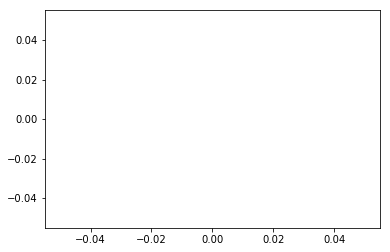

In [446]:
plt.plot(history.history["loss"])

In [447]:
w = model.layers[-1].get_weights()
weights = w[0]
biases = w[1]

In [448]:
embedder = Model(x, embedding)

In [449]:
embeddings = embedder.predict(node_representation)

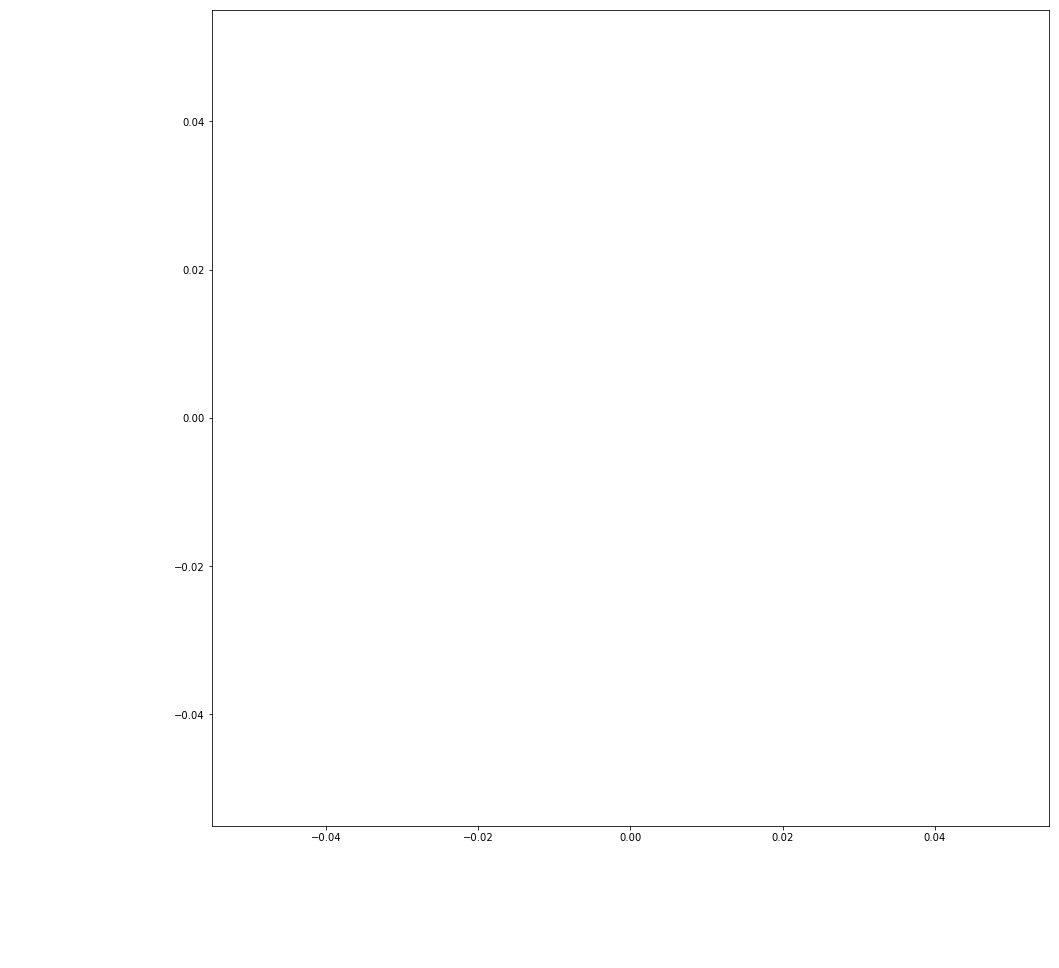

In [450]:
plt.figure(figsize=(15, 15))

for label, i, j in zip(genes_in_network, embeddings[:10, 0], embeddings[:10, 1]):
    plt.annotate(
        label,
        xy=(i, j), xytext=(-20, 20),
        textcoords='offset points', ha='right', va='bottom',
        bbox=dict(boxstyle='round,pad=0.5', fc='yellow', alpha=0.5),
        arrowprops=dict(arrowstyle = '->', connectionstyle='arc3,rad=0'))

nodes = np.array(G.nodes())
for n1, n2 in G.edges():
    i, = np.where(nodes == n1)
    j, = np.where(nodes == n2)
    plt.plot(embeddings[(i, j), 0], embeddings[(i, j), 1], c="k", 
             linewidth = 0.3)


plt.scatter(embeddings[:,0], embeddings[:,1], 
            c = c)

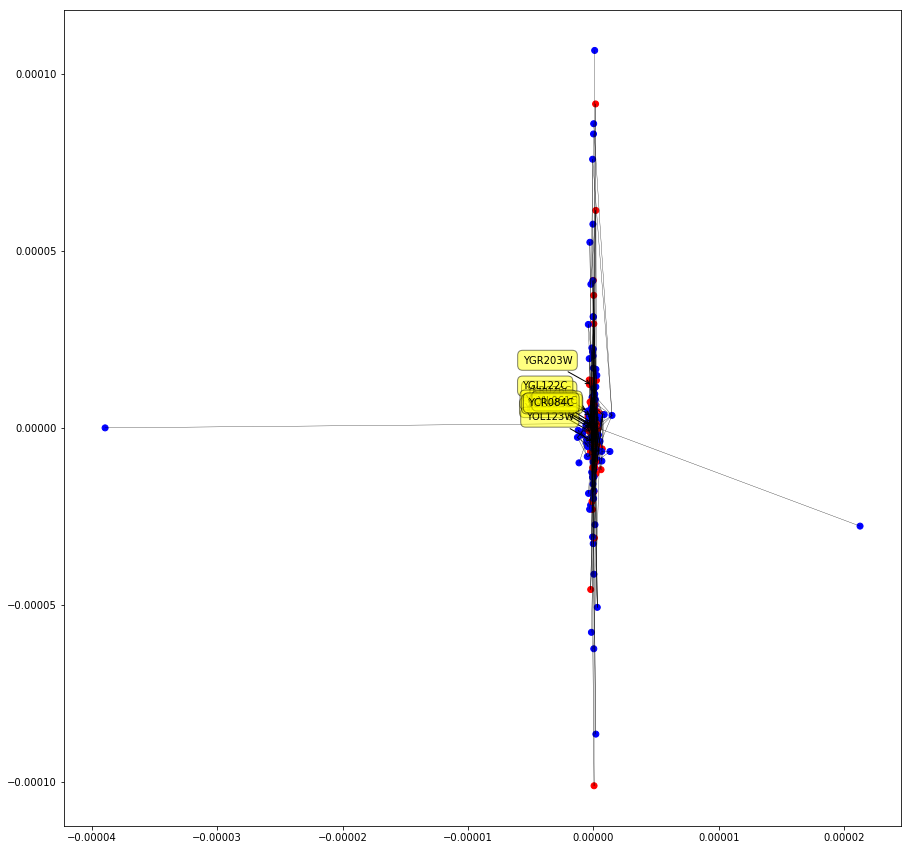

In [380]:
plt.figure(figsize=(15, 15))

for label, i, j in zip(genes_in_network, weights[0, :10], weights[1, :10]):
    plt.annotate(
        label,
        xy=(i, j), xytext=(-20, 20),
        textcoords='offset points', ha='right', va='bottom',
        bbox=dict(boxstyle='round,pad=0.5', fc='yellow', alpha=0.5),
        arrowprops=dict(arrowstyle = '->', connectionstyle='arc3,rad=0'))

nodes = np.array(G.nodes())
for n1, n2 in G.edges():
    i, = np.where(nodes == n1)
    j, = np.where(nodes == n2)
    plt.plot(weights[0, (i, j)], weights[1, (i, j)], c="k", 
             linewidth = 0.3)


plt.scatter(weights[0, :], weights[1, :], c = c)

In [52]:
predictions = model.predict(node_representation)

In [88]:
from numpy.linalg import eigh

In [97]:
H = max(nx.connected_component_subgraphs(G.to_undirected()), key=len)

In [98]:
B = np.array(nx.adjacency_matrix(H).todense())

In [105]:
B

array([[0, 1, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 1],
       [0, 0, 0, ..., 0, 1, 0]])

In [114]:
l, U = eigh(B)

In [115]:
idx = l.argsort()[::-1]
l = l[idx]
U = U[:, idx]

In [123]:
P = B * np.array([[U[j,0] / U[i,0] for j in range(B.shape[1])] for i in range(B.shape[0])]) / l[0]

In [125]:
P.sum(axis=1)

array([ 1.        ,  1.        ,  1.        ,  1.        ,  1.        ,
        1.        ,  0.99999999,  1.        ,  1.        ,  1.        ,
        1.        ,  1.        ,  1.        ,  1.        ,  1.        ,
        1.        ,  1.        ,  1.        ,  1.        ,  1.        ,
        1.        ,  1.        ,  1.        ,  1.        ,  1.        ,
        1.        ,  1.        ,  1.        ,  1.        ,  1.        ,
        1.        ,  1.        ,  1.        ,  1.        ,  1.        ,
        1.        ,  1.        ,  1.        ,  1.        ,  1.        ,
        1.        ,  1.        ,  1.        ,  1.        ,  1.        ,
        1.        ,  1.        ,  1.        ,  1.        ,  1.        ,
        1.        ,  1.        ,  1.        ,  1.        ,  1.        ,
        1.        ,  1.        ,  1.        ,  1.        ,  1.        ,
        1.        ,  1.        ,  1.        ,  1.        ,  1.        ,
        1.        ,  1.        ,  1.        ,  1.        ,  1.  

In [117]:
l[0]

5.063241497216362

In [118]:
U[:,0]

array([ -6.07203253e-08,  -3.07441671e-07,  -6.77829841e-05,
        -3.43201618e-04,  -1.58383562e-03,  -6.31849830e-08,
        -1.24791566e-08,  -5.15799842e-05,  -2.61161917e-04,
        -6.28432266e-02,  -1.24116589e-02,  -3.05778774e-01,
        -7.38076607e-08,  -1.86853005e-07,  -7.24658908e-07,
        -1.49444161e-07,  -1.43121537e-07,  -2.17330223e-07,
        -1.86853005e-07,  -2.63659023e-06,  -1.10911059e-05,
        -5.61569478e-05,  -8.74280185e-04,  -4.25401969e-03,
        -1.55406889e-02,  -4.25401969e-03,  -4.08134766e-03,
        -4.08134766e-03,  -3.40172376e-03,  -2.19878494e-02,
        -3.06931616e-03,  -3.06931616e-03,  -3.44646571e-03,
        -3.06931616e-03,  -3.19917156e-03,  -3.06931616e-03,
        -3.06931616e-03,  -3.40172376e-03,  -4.08134766e-03,
        -4.08134766e-03,  -7.35977706e-06,  -2.90714044e-06,
        -7.35977706e-06,  -3.37318764e-02,  -6.94445370e-03,
        -7.27793484e-03,  -6.93252813e-03,  -1.27055562e-01,
        -4.71874957e-03,

In [170]:
from keras.objectives import kullback_leibler_divergence
from keras.objectives import cosine

In [172]:
def custom_loss(y_true, y_pred):
    
    cos_sim = cosine_similarity(y_pred)
    
    p_values = cos_sim / cos_sim.sum(axis=1)[:, np.new_axis] 
    
    return kullback_leibler_divergence(y_true, p_values)